In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
from torchinfo import summary
from torch.utils.data import DataLoader

from models.ae_trainer import AETrainer

In [2]:
DATASET_PATH = os.path.join(os.getcwd(), 'data')

In [3]:
seed = 37
torch.manual_seed(seed)

In [4]:
class SensorDataset():
    def __init__(self, data: np.array):
        self.x = self.np2tensor(data)
        
    @staticmethod
    def np2tensor(x):
        return torch.tensor(x, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [5]:
latent_dims = 118
batch_size = 16
epochs = 1000

In [6]:
data_filename = 'data.mat'
data = loadmat(os.path.join(DATASET_PATH, data_filename))
Z = data['Z']
T = len(Z)
train_size = int(T * 0.8)
lr = 1e-1
scheduler = True
es_patience = 10

In [7]:
Z_train, Z_test = Z[:train_size], Z[train_size:]
training = SensorDataset(Z_train)
test = SensorDataset(Z_test)
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [8]:
trainer = AETrainer(latent_dim=latent_dims, lr=lr, 
                    lr_scheduler=scheduler, es_patience=es_patience, seed=seed)

In [9]:
summary(trainer.ae, (1, 358))

Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 358]                  --
├─Encoder: 1-1                           [1, 118]                  --
│    └─Linear: 2-1                       [1, 236]                  84,724
│    └─BatchNorm1d: 2-2                  [1, 236]                  472
│    └─Linear: 2-3                       [1, 118]                  27,966
├─Decoder: 1-2                           [1, 358]                  --
│    └─Linear: 2-4                       [1, 236]                  28,084
│    └─BatchNorm1d: 2-5                  [1, 236]                  472
│    └─Linear: 2-6                       [1, 358]                  84,846
Total params: 226,564
Trainable params: 226,564
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.23
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.91
Estimated Total Size (MB): 0.92

In [10]:
ae, mse, val_mse = trainer.train(train_dl, test_dl, epochs=epochs)

Epoch 1/1000: [MSE: 2.8000], [Val_MSE: 2.75], 
Validation loss decreased (inf --> 2.752378).  Saving model ...
Epoch 2/1000: [MSE: 2.7524], [Val_MSE: 2.75], 
Validation loss decreased (2.752378 --> 2.749776).  Saving model ...
Epoch 3/1000: [MSE: 2.7506], [Val_MSE: 2.74], 
Validation loss decreased (2.749776 --> 2.743768).  Saving model ...
Epoch 4/1000: [MSE: 2.7502], [Val_MSE: 2.75], 
EarlyStopping counter: 1 out of 10
Epoch 5/1000: [MSE: 2.7505], [Val_MSE: 2.75], 
EarlyStopping counter: 2 out of 10
Epoch 6/1000: [MSE: 2.7492], [Val_MSE: 2.77], 
EarlyStopping counter: 3 out of 10
Epoch 7/1000: [MSE: 2.7517], [Val_MSE: 2.74], 
Validation loss decreased (2.743768 --> 2.743767).  Saving model ...
Epoch 8/1000: [MSE: 2.7515], [Val_MSE: 2.74], 
EarlyStopping counter: 1 out of 10
Epoch 9/1000: [MSE: 2.7515], [Val_MSE: 2.75], 
EarlyStopping counter: 2 out of 10
Epoch 10/1000: [MSE: 2.7526], [Val_MSE: 2.75], 
EarlyStopping counter: 3 out of 10
Epoch 11/1000: [MSE: 2.7466], [Val_MSE: 2.74], 


In [11]:
def plot_learning(mse, val_mse):
    fig, axs = plt.subplots(1, figsize=(10,20))
    axs.plot(mse, color='r', label='Training')
    axs.plot(val_mse, color='b', label='Validation')
    axs.set_title('MSE Loss')
    plt.legend()
    #plt.savefig('./imgMix/mse-kl-mvae.pdf', format='pdf', dpi=1200)
    plt.show()

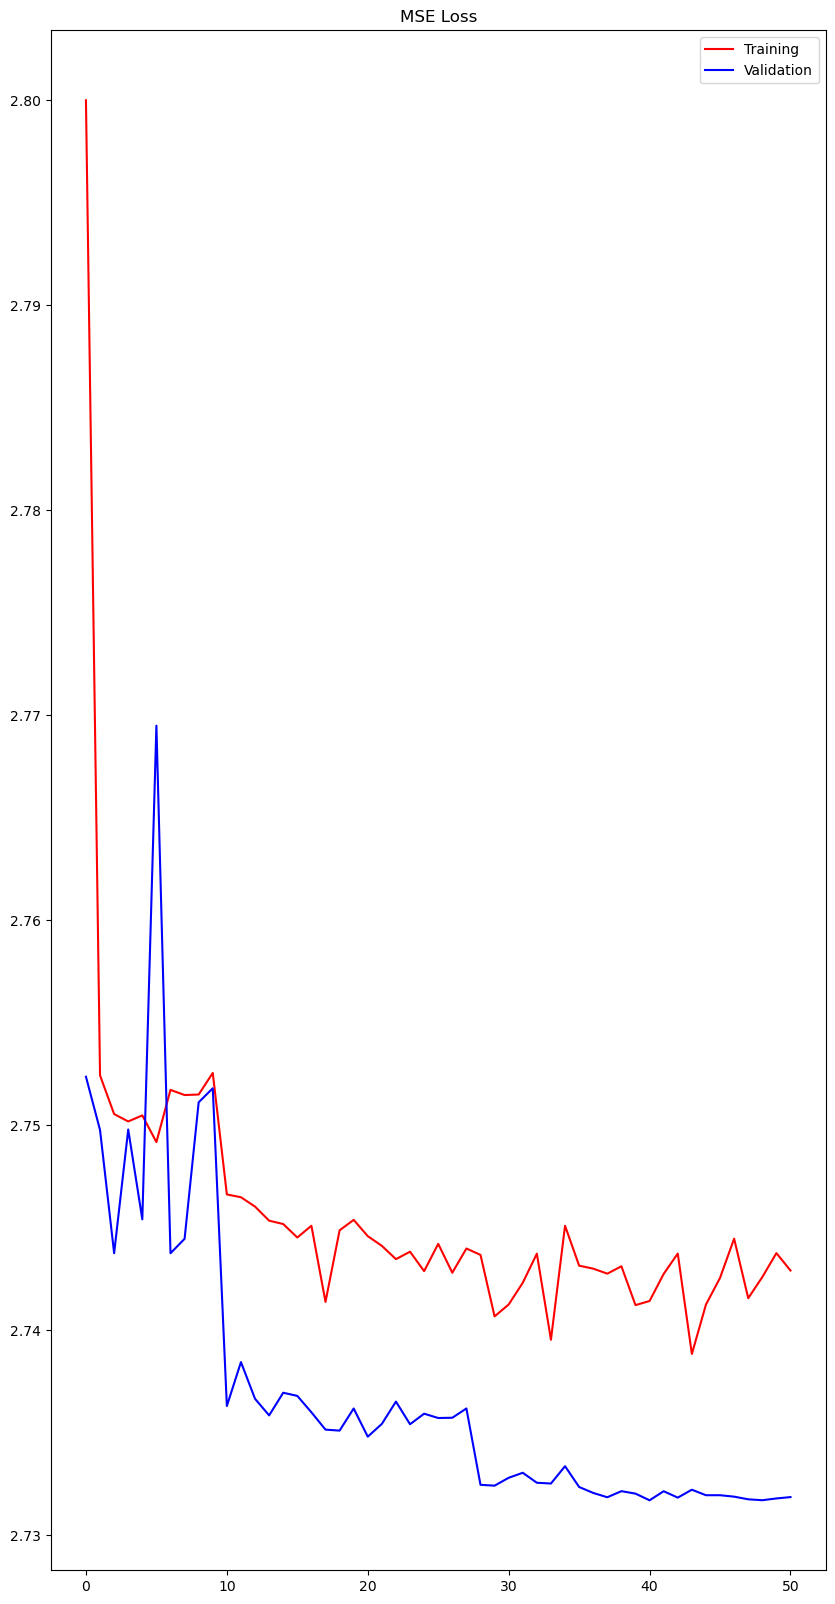

In [12]:
plot_learning(mse, val_mse)

In [13]:
ae.eval()
Z = torch.tensor(Z, dtype=torch.float32)
Z_enc = ae(Z)

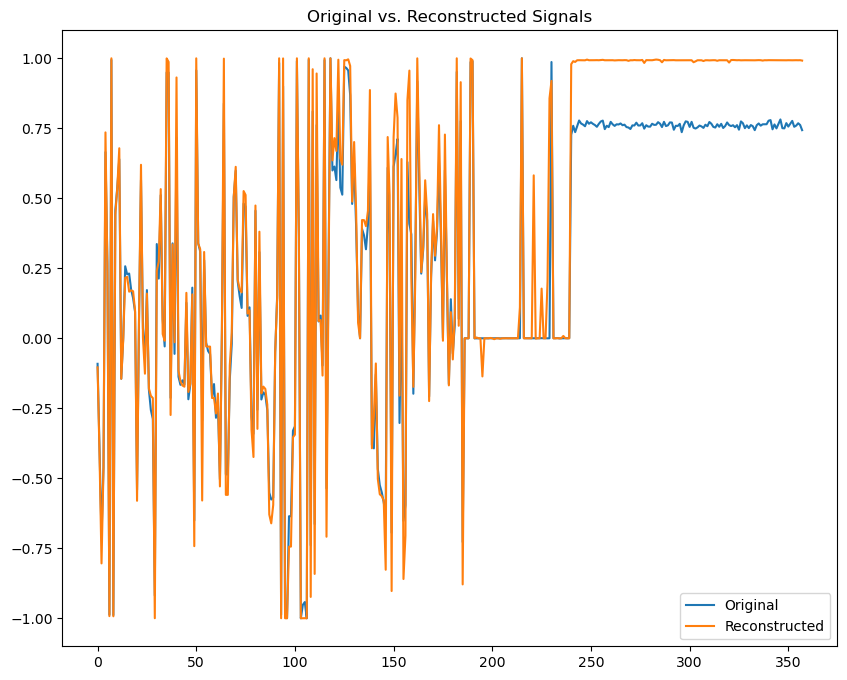

In [15]:
idx = 799
fig, axs = plt.subplots(figsize=(10,8))
axs.plot(np.transpose(torch.tanh(Z[idx,:]).cpu().detach().numpy()), label='Original')
axs.plot(np.transpose(Z_enc[idx,:].cpu().detach().numpy()), label='Reconstructed')
axs.set_title('Original vs. Reconstructed Signals')
plt.legend()
plt.show()